In [36]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd


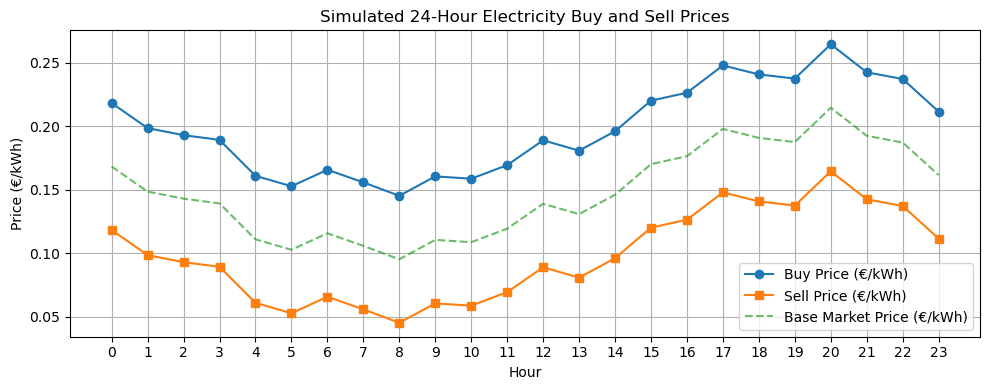

In [84]:
# Set seed for reproducibility
np.random.seed(42)

# === 1. Time Horizon ===
T = 24
horizon = 6
N=10
hours = np.arange(T)
base_price = 0.15
amplitude = 0.10
noise = np.random.normal(0, 0.01, size=T)

# Symmetric price
prices = base_price + amplitude * (
    np.sin((hours - 8) / 24 * 2 * np.pi) + np.sin((hours - 18) / 24 * 2 * np.pi)
) + noise
prices = np.clip(prices, 0.05, None)

# Add asymmetric buy/sell prices
margin = 0.05
buy_prices = prices + margin
sell_prices = prices - margin
sell_prices = np.clip(sell_prices, 0.01, None)  # Prevent negative prices

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(hours, buy_prices, label='Buy Price (€/kWh)', marker='o')
plt.plot(hours, sell_prices, label='Sell Price (€/kWh)', marker='s')
plt.plot(hours, prices, label='Base Market Price (€/kWh)', linestyle='--', alpha=0.7)
plt.title("Simulated 24-Hour Electricity Buy and Sell Prices")
plt.xlabel("Hour")
plt.ylabel("Price (€/kWh)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()


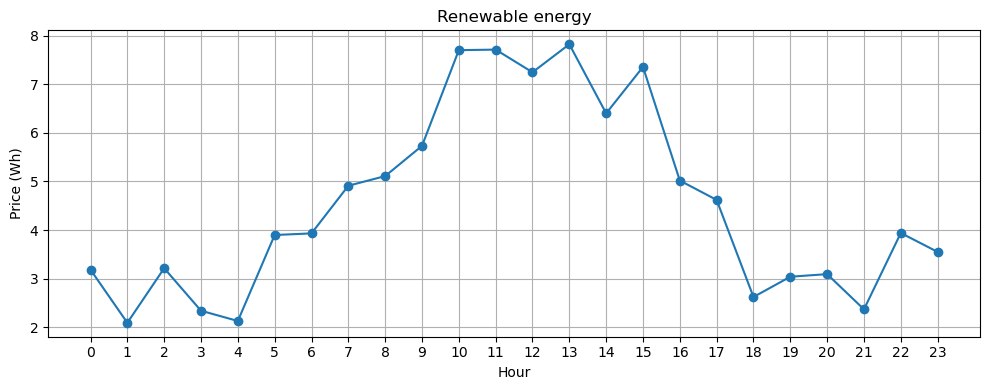

In [86]:
# === 3. Generate Renewable Energy ===
pv_gen = np.maximum(0, 5 * np.sin((hours - 6) * np.pi / 12))  # PV peaks at noon
wt_gen = 2 + np.random.rand(T) * 2  # Wind is random but consistent
renewable_gen = pv_gen + wt_gen

plt.figure(figsize=(10, 4))
plt.plot(np.arange(T), renewable_gen, marker='o')
plt.title("Renewable energy")
plt.xlabel("Hour")
plt.ylabel("Price (Wh)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

[4.71460216e-09 2.58933205e-09 1.59194349e-09 1.93686748e-09
 4.99853181e-09 2.19408286e-09 3.64145067e-09 1.24444710e-09
 1.16917614e-09 2.23094910e-09]
[3.63745849e-09 2.31994247e-09 1.70345253e-09 1.84514558e-09
 3.94139807e-09 2.07211408e-09 3.18143222e-09 1.33626941e-09
 1.25162232e-09 2.00983761e-09]
[7.49509274e-10 4.78244228e-10 3.58096766e-10 3.67412469e-10
 6.43038049e-10 3.83996681e-10 5.82950162e-10 2.66358040e-10
 2.78029078e-10 4.31945841e-10]
[2.80251709e-10 1.94440446e-10 1.47532581e-10 1.59380992e-10
 2.97296598e-10 1.75831913e-10 2.49337392e-10 1.19645429e-10
 1.12111192e-10 1.72850301e-10]
[2.06677565e-09 1.47469787e-09 1.14417877e-09 1.22954885e-09
 2.15402875e-09 1.33758870e-09 1.86101905e-09 9.30209146e-10
 8.81257765e-10 1.32149027e-09]
[1.50968826e-09 1.11310118e-09 8.62606979e-10 9.43360582e-10
 1.48021326e-09 9.78846313e-10 1.33468925e-09 6.97211535e-10
 6.78030916e-10 1.03123888e-09]
[5.21819703e-10 3.84517835e-10 2.98988291e-10 3.34301795e-10
 5.53182664e-10

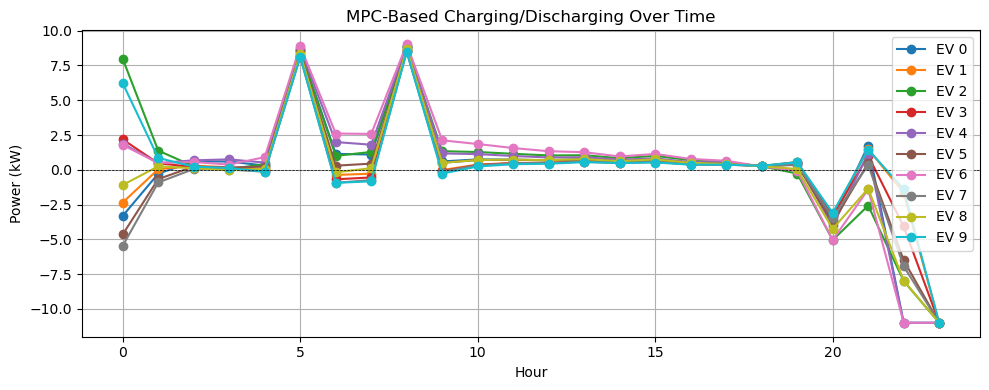

In [98]:
# EV battery parameters
evcap_max = np.random.uniform(40, 80, N)
evcap_min = 0.33 * evcap_max
evcap_target = np.random.uniform(30, evcap_max)
soc = np.random.uniform(10, 30, N)  # initial SoC
soc_log = np.zeros((N, T + 1))
soc_log[:, 0] = soc

# Charging limits
ch_max = 11

# Store charging actions
charging_action_log = np.zeros((N, T))

# === MPC Loop ===
for t in range(T):
    h = min(horizon, T - t)

    # Variables
    x = cp.Variable((N, h))  # charging/discharging
    miss = cp.Variable(N)
    grid_draw = cp.Variable(h)
    grid_feed = cp.Variable(h)

    constraints = []

    for i in range(N):
        # Charging power limits
        constraints += [x[i, :] >= -ch_max, x[i, :] <= ch_max]
        # SoC constraints
        soc_h = soc[i] + cp.cumsum(x[i, :])
        constraints += [soc_h >= evcap_min[i], soc_h <= evcap_max[i]]
        # Final SoC + shortfall ≥ target
        constraints += [soc[i] + cp.sum(x[i, :]) + miss[i] >= evcap_target[i]]
        constraints += [miss[i] >= 0]

    total_charging = cp.sum(x, axis=0)
    constraints += [grid_draw >= 0, grid_feed >= 0]
    constraints += [total_charging + grid_feed - grid_draw == renewable_gen[t:t + h]]

    # Objective
    energy_cost = cp.sum(cp.multiply(buy_prices[t:t + h], grid_draw) -
                         cp.multiply(sell_prices[t:t + h], grid_feed)) / cp.sum(renewable_gen[t:t + h])
    charge_penalty = cp.sum(miss / evcap_target)
    objective = cp.Minimize(energy_cost + charge_penalty)

    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CLARABEL)

    # Apply only the first decision
    if x.value is not None:
        charging_action_log[:, t] = x.value[:, 0]
        soc += x.value[:, 0]
        soc_log[:, t + 1] = soc
    else:
        charging_action_log[:, t] = 0
        soc_log[:, t + 1] = soc

    print(miss.value)

# === Plot Charging Actions ===
plt.figure(figsize=(10, 4))
for i in range(N):
    plt.plot(range(T), charging_action_log[i], marker='o', label=f'EV {i}')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title("MPC-Based Charging/Discharging Over Time")
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

ValueError: x, y, and format string must not be None

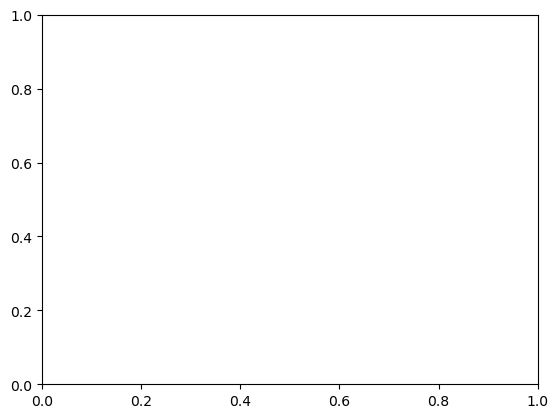

In [94]:
plt.plot(np.arange(N),miss.value)

In [64]:
x.value

array([[ -2.14325047,   0.53268509,   0.32210632,   0.37444749,
          0.35579106,  10.99999998,   0.64673772,   6.88108899,
         10.99999999,   0.77629021,   0.60686905,   0.63516742,
          0.71576053,   0.76550174,   0.80623588,   0.73667926,
          0.45602318,   0.43188601,   0.29876944,   0.37745964,
        -10.99999998,   0.87553276,   1.38191404,   1.64427818],
       [  2.42626979,   0.54559043,   0.33444015,   0.38480022,
          0.44043715,  10.99999998,   2.36126714,   7.66230984,
         10.99999999,   1.90579226,   1.20788869,   0.93804345,
          0.86802491,   0.84652183,   0.85429669,   0.76702907,
          0.47321212,   0.44406573,   0.29876607,   0.32404746,
        -10.99999997,   0.90049172,   1.7210067 ,   2.27563544],
       [  6.97033573,   0.54629864,   0.33948349,   0.37302382,
          0.29819417,  10.99999998,  -0.7848174 ,   5.92677915,
         10.99999999,  -0.08930092,   0.20850359,   0.44583768,
          0.61666189,   0.70539674,   